# QOSF Mentorship Programme
## Frederik Hardervig
### Task 3 - Transpiler to RX, RZ, CZ

Being most comfortable with Qiskit, I chose it as the starting point for my program. It has many useful objects such as the quantum circuit and gates, allowing the code below to be focused on the task at hand, rather than doing low-level implementations of the gates.

My overall approach to finding identities for each gate using RX, RZ, and CZ was primarily thinking about rotations on the Bloch sphere and trying to replicate them while constrained to rotations about the X and Z axis. The general idea was to find a way to change basis onto the computational basis, perform the desired operation, then go back. I also found an old piece of code I had lying around that creates a Bloch Sphere from a given circuit which I used to doublecheck the single qubit gates. It can be found in appendix A. Let's take a look at the identities for now.

In [1]:
#Let's first import some important libraries
#Framework for our quantum circuits and gates
from qiskit import *
from qiskit import QuantumCircuit

#Plotting
%matplotlib inline
import matplotlib.pyplot as plt

#Purely for having pi
import math

## The identities

In [2]:
#Identities
def transpile_I(output_circuit, index):
    #No-rotation is equivalent to doing nothing and doesn't
    #change the relative phase, while still taking up one gate wait cycle.
    #From what I understand from the Qiskit documentation, 
    #we do not want identity gates to be optimized, as if it used
    #it has to do with the timing of the circuit.
    output_circuit.rz(0, index)

def transpile_H(output_circuit, index):
    #From instructions.
    output_circuit.rz(math.pi/2, index)
    output_circuit.rx(math.pi/2, index)
    output_circuit.rz(math.pi/2, index)

    
def transpile_X(output_circuit, index):
    #X is just a pi rotation around the x axis
    output_circuit.rx(math.pi, index)

def transpile_Y(output_circuit, index):
    #By combining a flip around x and z, you can make transformation corresponding to a flip around y.
    output_circuit.rx(math.pi, index)
    output_circuit.rz(math.pi, index)

def transpile_Z(output_circuit, index):
    #Z is just a pi rotation around the Z axis
    output_circuit.rz(math.pi, index)

def transpile_RX(output_circuit, index, angle):
    #RX is one of our basis gates, so it replaces itself
    output_circuit.rx(angle, index)

def transpile_RY(output_circuit, index, angle):
    #Rotate basis into y so that the eigenstates of the z rotation is the y states,
    #perform the given rotation, then go back.
    #If the sign of the x rotations are changed, so must the y rotation, so I kept the
    #positive x rotation first leaving the z rotation also positive.
    output_circuit.rx(math.pi/2, index)
    output_circuit.rz(angle, index)
    output_circuit.rx(-math.pi/2, index)

def transpile_RZ(output_circuit, index, angle):
    #RZ is one of our basis gates, so it replaces itself
    output_circuit.rz(angle, index)
    
def transpile_CX(output_circuit, index, target):
    #The hadamard switches between the Z and X basis, so we switch basis, 
    #do the controlled flip around Z, then convert back effectly flipping around X.
    #If the controlled Z is not activated, the Hadamards cancel out.
    transpile_H(output_circuit, target)
    output_circuit.cz(index, target)
    transpile_H(output_circuit, target)

def transpile_CY(output_circuit, index, target):
    #Rotate target to y basis, controlled flip, convert back.
    output_circuit.rx(math.pi/2, target)
    output_circuit.cz(index, target)
    output_circuit.rx(-math.pi/2, target)    

def transpile_CZ(output_circuit, index, target):
    #Already one of our basis gates.
    output_circuit.cz(index, target)

## The transpiler
Now that we have our identities defined, it's time to construct out transpiler. Since qiskit already has the circuit object, let's just feed a circuit to our transpiler. Since we already have the basis gates we're transpiling to, we don't need any other inputs.

In [3]:
def RXRZCZ_transpiler(input_circuit):
    #Creates a new quantumcircuit with registers matching the size of the input circuit.
    #The circuits may sometime not have a classical register, so we include a checker for this
    if len(input_circuit.cregs) > 0:
        output_circuit = QuantumCircuit(len(input_circuit.qregs[0]),len(input_circuit.cregs[0]))
    else:
        output_circuit = QuantumCircuit(len(input_circuit.qregs[0]))        

    #For all gates in the input_circuit retrieve the gate object and list of qubits for the given gate.
    for Gate, Qubit, _ in input_circuit._data:
        #Retrieve the index of the Qubit it should be applied to.
        index = Qubit[0].index
        
        #If the gate object matches, transpile it to one of our pre-defined identities.
        if type(Gate) == qiskit.circuit.library.standard_gates.h.HGate:
            transpile_H(output_circuit, index)
            
        elif type(Gate) == qiskit.circuit.library.standard_gates.x.XGate:
            transpile_X(output_circuit, index)
            
        elif type(Gate) == qiskit.circuit.library.standard_gates.y.YGate:
            transpile_Y(output_circuit, index)
        
        elif type(Gate) == qiskit.circuit.library.standard_gates.z.ZGate:
            transpile_Z(output_circuit, index)
        
        #In addition to the target qubit, the rotation gates also needs the angle as a parameter.
        #Luckily, we can extract this angle from the Gate object we fed as a part of our ciruit.
        elif type(Gate) == qiskit.circuit.library.standard_gates.rx.RXGate:
            theta = Gate.params[0]
            transpile_RX(output_circuit, index, theta)
        
        elif type(Gate) == qiskit.circuit.library.standard_gates.ry.RYGate:
            theta = Gate.params[0]
            transpile_RY(output_circuit, index, theta)
        
        elif type(Gate) == qiskit.circuit.library.standard_gates.rz.RZGate:
            theta = Gate.params[0]
            transpile_RZ(output_circuit, index, theta)
        
        #Our controlled gates needs to have both a target and control qubit defined.
        #Again, the circuit object takes care of this, so the second qubit in the qubit list 
        #contains the target index.
        elif type(Gate) == qiskit.circuit.library.standard_gates.x.CXGate:
            target = Qubit[1].index
            transpile_CX(output_circuit, index, target)
            
        elif type(Gate) == qiskit.circuit.library.standard_gates.y.CYGate:
            target = Qubit[1].index
            transpile_CY(output_circuit, index, target)
        
        elif type(Gate) == qiskit.circuit.library.standard_gates.z.CZGate:
            target = Qubit[1].index
            transpile_CZ(output_circuit, index, target)
        
        
        #I put the identity gate in the end, since I don't see the gate being used very often.
        #The general ordering of the gates could potentially be optimized 
        #depending on what gates are more often used, but this is sufficient for now.
        elif type(Gate) == qiskit.circuit.library.standard_gates.i.IGate:
            transpile_I(output_circuit, index)
            
        else:
            #If we don't have an identity for the type of gate, print the type and raise an error.
            print(type(Gate))
            raise TypeError("This gate is not support by this transpiler (or you did not input a valid quantum circuit).")
    
    #Return the transpiled circuit.
    return output_circuit   

## Testing the transpiler and discussion on global phase
Now that we have the transpiler, it's time to test it out! We'll be drawing out the original and transpiled circuit, and use Qiskit to visualize their resulting system of states with the qsphere. If you aren't familiar with the qsphere, here's a [2 minute introduction](https://youtu.be/4SoK2h4a7us).

In [4]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere

To test the basics, we will create a circuit consisting only of basis gates and the given hadamard decomposition.

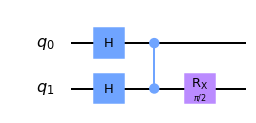

In [5]:
#To test our controlled gate, we'll use two qubits, and include no classical register 
#since we aren't doing any measurements.
q = QuantumCircuit(2)

#Apply a hadamard to both qubits, the a cz with qubit 1 as control and 0 as target,
#then finally we rotate qubit 1 around the x axis.
q.h([0,1])
q.cz(1,0)
q.rx(math.pi/2, 1)

#Draw out the circuit.
q.draw(output='mpl')

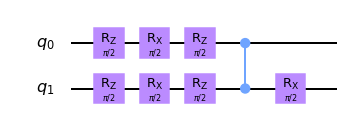

In [6]:
#We then send the circuit to the transpiler and draw it.
qc = RXRZCZ_transpiler(q)
qc.draw(output='mpl')

The transpiler seems to be working as intended. Let's simulate both circuits and look at the resulting state of the system.

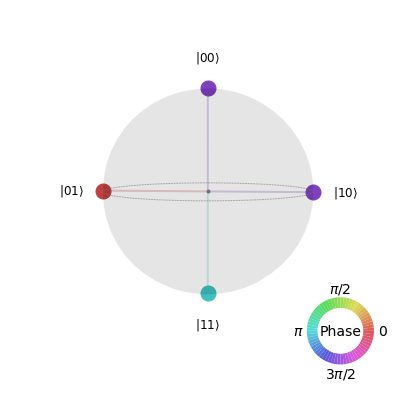

In [7]:
#First we simulate the initial circuit
state = Statevector.from_instruction(q)
plot_state_qsphere(state)

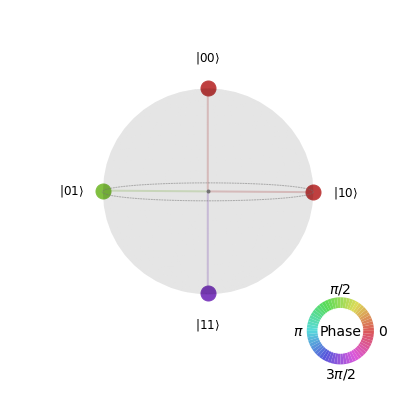

In [8]:
#We then simulate the transpiled circuit
state1 = Statevector.from_instruction(qc)
plot_state_qsphere(state1)

While the circuit above was not the first one I tried, I quickly found out that the global phase had been somehow changed. After testing various circuits, I concluded the issue was lying in the hadarmard decomposition we were given. While the global phase of course has absolutely no influence over our measurements, I still found this interesting, and decided to double-check analytically whether the errors were truly stemming from the decomposition we were given.

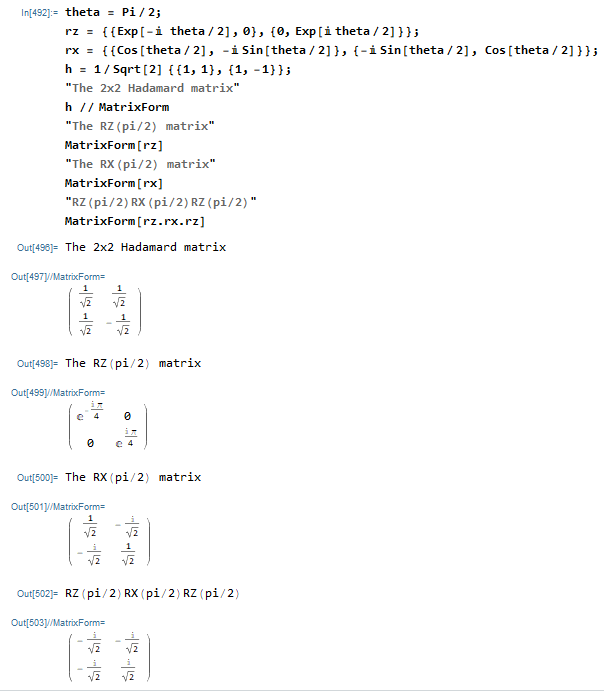

In [9]:
from IPython.display import Image
Image("QOSF Hadamard.PNG")

Turns out our decomposition introduces a $-i$, which is where our $\pi/2$ phase error stems from. Anyhow, while we could indeed try to keep track of the global error using a seperate variable, it really doesn't make a difference to our measurements, and would then require us to add an additioanl RZ gate at the end the circuit of each qubit to correct their global phase.

## Evaluating overhead
Let us instead focus on a more complicated circuit:

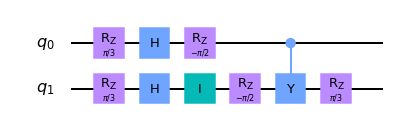

In [10]:
q = QuantumCircuit(2)

q.rz(math.pi/3, [0,1])
q.h([0,1])
q.i(1)
q.rz(-math.pi/2, [0,1])
q.cy(0,1)
q.rz(math.pi/3, 1)
q.draw(output='mpl')

Which transpiles into this:

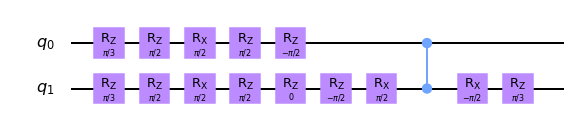

In [11]:
qc = RXRZCZ_transpiler(q)
qc.draw(output='mpl')

We can see that both the amount of gates and the depth of the circuit is increased. Namely, the amount of gates goes from 9 to 15 and our circuit depth from 6 to 10. Teoretically, our worst case scenario would be a seven-doubling of both as our identity for the controlled X gate, uses two decomposed Hadamards and a CZ, turning one gate into 7, though all other gates decompose into three gates at most. Let's see this worst case scenario.

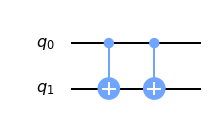

In [12]:
q2 = QuantumCircuit(2)

q2.cx(0,1)
q2.cx(0,1)
q2.draw(output='mpl')

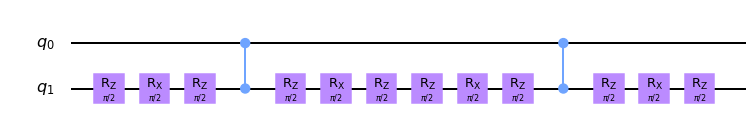

In [13]:
qc2 = RXRZCZ_transpiler(q2)
qc2.draw(output='mpl')

However, we can see in our circuits that some of our gates commute, namely, any RZ or RX gates in succession. Intuitively, if you rotate around the same axis multiple times, the order does not matter, and the resulting rotation will simply be the sum of all rotation angles. The exception to the is the RZ(0) that is our transpiled identity which we do not wish to optimize away as it may help with the timing on the physical computers.

## The optimizer
In order to cut down gate amount and circuit depth, we write an optimizer that takes advantage of this commutation, while still paying close attention to the ordering of the gates and not removing the RZ(0).

In [14]:
def cummutative_optimizer(input_circuit):
    #Creates a new quantumcircuit with registers matching the size of the input circuit.
    #The circuits may sometime not have a classical register, so we include a checker for this
    if len(input_circuit.cregs) > 0:
        output_circuit = QuantumCircuit(len(input_circuit.qregs[0]),len(input_circuit.cregs[0]))
    else:
        output_circuit = QuantumCircuit(len(input_circuit.qregs[0]))     
    
    #List to hold the type of the previous gate for each qubit. Index corresponds to qubit number.
    prev_Gate_list = [{"Gate": None, "Qubit": None}]*len(input_circuit.qregs[0])
    init_Gate, init_Qubit, _ = input_circuit._data[0]
    prev_Gate_list[init_Qubit[0].index] = {"Gate": init_Gate, "Qubit": init_Qubit}
    
    #For all gates in the input_circuit
    for i in range(1, len(input_circuit._data)):
        cur_Gate = input_circuit[i][0]
        cur_Qubit = input_circuit[i][1]
        cur_index = cur_Qubit[0].index
        if cur_Gate.name == "cz":
            #Since cz gates interact with more than one qubit, we deal with them immediately, to maintain ordering.
            #However, this also means we won't be optimizing if two identical CZs in a row ever occurs, 
            #although this situation should never arise practically as they would cancel to the identity operator anyway.
            target = cur_Qubit[1].index

            #Apply any queued gates to the control and target qubit to uphold ordering
            #If there is no queued gate, go to the next entry
            if prev_Gate_list[cur_index]["Gate"] == None:
                pass
            #If the total rotation of the gate is 0, we ignore it. This will be used repeatedly in the code.
            elif prev_Gate_list[cur_index]["Gate"].params[0] == 0:
                pass
            elif prev_Gate_list[cur_index]["Gate"].name == "rz":
                output_circuit.rz(prev_Gate_list[cur_index]["Gate"].params[0], cur_index)
            elif prev_Gate_list[cur_index]["Gate"].name == "rx":
                output_circuit.rx(prev_Gate_list[cur_index]["Gate"].params[0], cur_index)
            
            if prev_Gate_list[target]["Gate"] == None:
                pass
            elif prev_Gate_list[target]["Gate"].params[0] == 0:
                pass
            elif prev_Gate_list[target]["Gate"].name == "rz":
                output_circuit.rz(prev_Gate_list[target]["Gate"].params[0], target)
            elif prev_Gate_list[target]["Gate"].name == "rx":
                output_circuit.rx(prev_Gate_list[target]["Gate"].params[0], target)

            #Empty the control and target qubits gate queue
            prev_Gate_list[cur_index]["Gate"] = None
            prev_Gate_list[cur_index]["Qubit"] = None
            prev_Gate_list[target]["Gate"] = None
            prev_Gate_list[target]["Qubit"] = None

            #Now apply the cz gate
            output_circuit.cz(cur_index, target)
        
        #If we encounter a RZ gate with a rotation of 0, we assume it to be the transpiled identity gate
        #and thus we add any queued gate before it, and then add the 0 rotation.
        #While theoretically, this has no purpose, it may have a practical effect in terms of the timing on the real hardware.
        elif cur_Gate.name == "rz" and cur_Gate.params[0] == 0:
            if prev_Gate_list[cur_index]["Gate"].params[0] == 0:
                pass
            elif prev_Gate_list[cur_index]["Gate"].name == "rz":
                output_circuit.rz(prev_Gate_list[cur_index]["Gate"].params[0], cur_index)
            elif prev_Gate_list[cur_index]["Gate"].name == "rx":
                output_circuit.rx(prev_Gate_list[cur_index]["Gate"].params[0], cur_index)
            
            prev_Gate_list[cur_index]["Gate"] = None
            prev_Gate_list[cur_index]["Qubit"] = None
            
            output_circuit.rz(cur_Gate.params[0], cur_index)
            
        
        #If two rotation gates of the same type occur in a row, we substitute with the sum of their rotation.
        elif type(prev_Gate_list[cur_index]["Gate"]) == type(cur_Gate):
            if cur_Gate.name == "rz" or cur_Gate.name == "rx":
                prev_Gate_list[cur_index]["Gate"].params[0] += cur_Gate.params[0]
            else:
                print(type(cur_Gate))
                raise TypeError("You should pass the circuit through the RXRZCZ transpiler before applying the optimizer.")
        
        #If there are no gates currently queue, queue the coming one
        elif type(prev_Gate_list[cur_index]["Gate"]) == type(None):
            prev_Gate_list[cur_index]["Gate"] = cur_Gate
            prev_Gate_list[cur_index]["Qubit"] = cur_Qubit
        
        #If the gate didn't match the queued one, they don't commute, so we add the queued gate
        #to the circuit, and queue the current gate.
        else:
            #If the commutative angles cancelled out, don't add a gate
            if prev_Gate_list[cur_index]["Gate"].params[0] == 0:
                pass
            #Otherwise, add the appropriate gate
            elif prev_Gate_list[cur_index]["Gate"].name == "rz":
                output_circuit.rz(prev_Gate_list[cur_index]["Gate"].params[0], cur_index)
            elif prev_Gate_list[cur_index]["Gate"].name == "rx":
                output_circuit.rx(prev_Gate_list[cur_index]["Gate"].params[0], cur_index)
            #Sanity check since a controlled gate should never be queued to preserve ordering.
            elif prev_Gate_list[cur_index]["Gate"].name == "cz":
                raise RuntimeError("This should not have occured as all controlled gates should be instantly added to maintain ordering, and thus a CZ gate should not have existed in prev_Gate_list")
            else:
                print(type(cur_Gate))
                raise TypeError("You should pass the circuit through the RXRZCZ transpiler before applying the optimizer.")

            
            prev_Gate_list[cur_index]["Gate"] = cur_Gate
            prev_Gate_list[cur_index]["Qubit"] = cur_Qubit
    
    #Add the last of the queued gates to the circuit
    for i in prev_Gate_list:
        #If there is no queued gate, go to the next entry
        if i["Gate"] == None:
            continue
        #If the commutative angles cancelled out, don't add a gate
        elif i["Gate"].params[0] == 0:
            pass
        elif i["Gate"].name == "rz":
            output_circuit.rz(i["Gate"].params[0], i["Qubit"][0].index)
        elif i["Gate"].name == "rx":
            output_circuit.rx(i["Gate"].params[0], i["Qubit"][0].index)
        #Sanity check since a controlled gate should never be queued to preserve ordering.
        elif i["Gate"].name == "cz":
            raise RuntimeError("This should not have occured as all controlled gates should be instantly added to maintain ordering, and thus a CZ gate should not have existed in prev_Gate_list")
        else:
            print(type(cur_Gate))
            raise TypeError("You should pass the circuit through the RXRZCZ transpiler before applying the optimizer.")
        
    
    return output_circuit

Good, now let us revisit our circuit and try to transpile, then optimize.

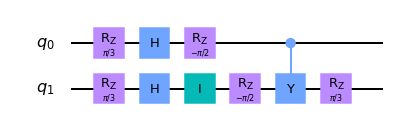

In [15]:
#Same circuit as before
q = QuantumCircuit(2)

q.rz(math.pi/3, [0,1])
q.h([0,1])
q.i(1)
q.rz(-math.pi/2, [0,1])
q.cy(0,1)
q.rz(math.pi/3, 1)
q.draw(output='mpl')

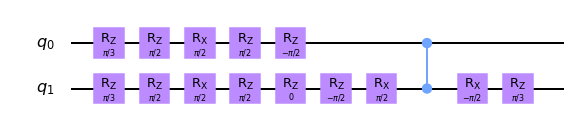

In [16]:
qc = RXRZCZ_transpiler(q)
qc.draw(output='mpl')

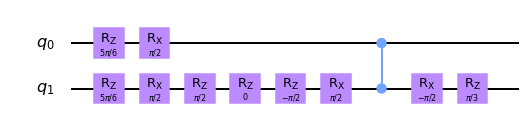

In [17]:
optim = cummutative_optimizer(qc)
optim.draw(output='mpl')

Above, we see that our optimizer succeeds in removing 4 gates and reducing our circuit depth by 1. Two of the gates are removed in the beginning as the RZ(pi/3) and RZ(pi/2) can be combined to a RZ(5pi/6) on both qubits. On q0, we also see that RZ(pi/2) and RZ(-pi/2) cancel out, saving us another two gates.
As such, the amount of gates goes from 9 originally, to 15 when transpiled and 11 once optimized, and our depth from 6 to 10 back down to 9. Of course, these numbers will vary. With the chosen decompositions and basis gates, I don't believe much more optimization can be done in a trivial manner, as without the RY gate the CX cannot be made any smaller and in general I believe that all the identities are essentially as efficient as they get.

As such, the only other way of optimization I see, is optimizing the original circuit in a way that would leave us at the original final state. An example of this can be seen when we look at how the optimizer handles our worst case scenario.

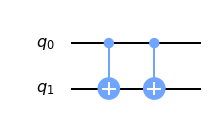

In [18]:
q2 = QuantumCircuit(2)

q2.cx(0,1)
q2.cx(0,1)
q2.draw(output='mpl')

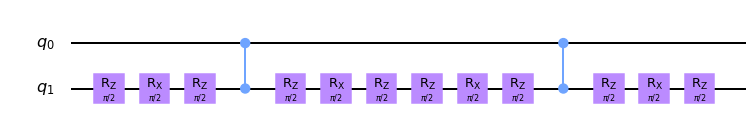

In [19]:
qc2 = RXRZCZ_transpiler(q2)
qc2.draw(output='mpl')

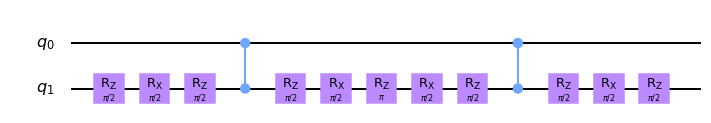

In [20]:
optim2 = cummutative_optimizer(qc2)
optim2.draw(output='mpl')

We see that the original gate count and circuit is 2, jumping to 14, then getting optimized to 13. This isn't exactly a huge improvement, especially when you consider the CX gates. If we had also implemented an optimizer at the non-transpiled level, we could have easily removed both of these gates, since if the control is 0 they leave the target unchanged, while with a control of 1 they flip the target, only to flip it back and leaving it at 0. In other words, the CX gate is hermitian and cancels itself out, which is obvious from the non-transpiled circuit, but not after transpilation.

As such, an extension of this work would be to work on optimizing the circuit before transpilation, then transpile and run the optimization pass that I created in this notebook.

## Final words

Congratulations on making it this far and thank you so much for your time! This was a lot of fun! I've never coded a project like this using Qiskit, so getting that extra push to actually go and do it was really helpful. I am really happy about the concepts I got to cover, and while I didn't necessarily learn a lot of new stuff, it definitely reinforced what I already knew and forced me to actually go apply it which is alwas great. Having me reflect on what more could be done in terms of optimization has really given me more blood on the tooth for diving deeper into circuit optimization methods, so I guess it's time for me to look at that ZX-calculus at some point over the next year.

The appendix is really not related to the project, but was just a sanity checker for my identities. Feel free to play around, but otherwise, you're free for now :) Enjoy your day, and I look forward to hear back from you!

# Appendix A:

In [21]:
#We first import pi and matplotlib
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline

#When then import everything from qiskit, and more specifically the
#function for plotting a statevector in a bloch sphere.
#from qiskit import *
from qiskit.visualization import plot_bloch_vector

# Import Aer, the library containing methods for simulation
from qiskit import Aer
# We import the qasm_simulator which simulates the noise one would
# see while using NISQ devices.
backend = Aer.get_backend('qasm_simulator')

shots = 10000 #Try to set me to 1, 10, 100, 1000, 10 000 and run the circuit below!

# Z measurement of qubit 0
measure_z = QuantumCircuit(1,1)
measure_z.measure(0,0)

# X measurement of qubit 0
measure_x = QuantumCircuit(1,1)
measure_x.h(0)
measure_x.measure(0,0)

# Y measurement of qubit 0
measure_y = QuantumCircuit(1,1)
measure_y.sdg(0)
measure_y.h(0)
measure_y.measure(0,0);

# Our function takes the single qubit quantum circuit 'qc'
def simulate_circuit(qc):
    bloch_vector = [] #We create a list to store the information for each basis.
    for measure_circuit in [measure_x, measure_y, measure_z]: #We measure for each basis

        # Run the circuit with a the selected measurement and get the number of samples that output each bit value
        # We execute our circuit, add the transformation into the basis we care about (measure_circuit), 
        # use the QASM backend, and sample equal to the amount of 'shots'.
        counts = execute(qc+measure_circuit, backend,shots=shots).result().get_counts()
        # We then calculate the probabilities for each bit value
        probs = {}
        for output in ['0','1']:
            if output in counts:
                probs[output] = counts[output]/shots
            else:
                probs[output] = 0
        bloch_vector.append( probs['0'] -  probs['1'] )
    #We then return the bloch vector containing probabilities for each basis.
    return bloch_vector

     ┌──────────┐┌──────────┐┌───────────┐
q_0: ┤ RX(pi/2) ├┤ RZ(pi/4) ├┤ RX(-pi/2) ├
     └──────────┘└──────────┘└───────────┘
[0.7083999999999999, -0.015600000000000003, 0.7043999999999999]


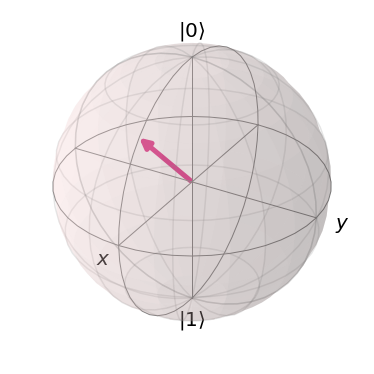

In [22]:
# We create a quantum circuit with just 1 qubit.
qc = QuantumCircuit(1)

qc.rx(math.pi/2, 0)
qc.rz(math.pi/4, 0)
qc.rx(-math.pi/2, 0)

# We send the circuit to our simulator
print(qc)
result = simulate_circuit(qc)

# And plot the resulting statevector on a bloch sphere
print(result)
plot_bloch_vector(result)